# WSI - ćwiczenie 5.
#### Sieci neuronowe

Klasa implementująca perceptron wielowarstwowy jest zawarta w pliku multilayer_perceptron.py.  
Funkcja implementująca uczenie perceptronu metodą stochastycznego najszybszego spadku jest zawarta w pliku perceptron_training.py.  
Pomocnicze funkcje do przygotowania zbioru danych i oceny wyników są zawarte w pliku training_helpers.py.  
Funkcje aktywacji również zostały przygotowane w pliku training_helpers.py.  
Funkcje rysujące wykresy są zawarte w pliku plots.py.


In [1]:
import sklearn.datasets
import numpy as np
import training_helpers
import perceptron_training
import multilayer_perceptron
import plots
%matplotlib inline

Zaczynam od załadowania zbioru danych funkcją load_wine z biblioteki sklearn.  
Dzielę go na zbiór treningowy, walidacyjny i testowy.

Wykonywane jest też przygotowanie zbiorów treningowego i walidacyjnego, czyli:  
* klasy [0, 1, 2] są zamieniane na oczekiwane przewidywania perceptronu, czyli [[1, 0, 0], [0, 1, 0], [0, 0, 1]], funkcją prepare_targets
* wejścia i wyjścia są normalizowane, tj. ich średnia jest doprowadzana do 0, a odchylenie standardowe do 1 przekształceniem liniowym, funkcjami get_normalizations oraz normalize_sequence.  
Najpierw uzyskiwane są funkcje normalizujące ze zbioru treningowego, a potem są one wykorzystywane do normalizacji zbiorów treningowego i walidacyjnego.

In [2]:
TRAIN_SIZE = 0.7
VALID_SIZE = 0.15

X_all, Y_all = sklearn.datasets.load_wine(return_X_y=True)
classes = list(set(Y_all))
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = training_helpers.triple_split(X_all, Y_all, TRAIN_SIZE, VALID_SIZE)

Y_train_prepared = training_helpers.prepare_targets(Y_train, classes)
normalize_X, normalize_Y, _ = training_helpers.get_normalizations(X_train, Y_train_prepared)

X_train_normal = training_helpers.normalize_sequence(X_train, normalize_X)
Y_train_normal = training_helpers.normalize_sequence(Y_train_prepared, normalize_Y)

X_validation_normal = training_helpers.normalize_sequence(X_validation, normalize_X)
Y_validation_normal = training_helpers.normalize_sequence(training_helpers.prepare_targets(Y_validation, classes), normalize_Y)

print(f"Ilość atrybutów w jednej próbce: {X_all.shape[1]}\n")

print(f"Zbiór treningowy: {len(X_train)} elementów - {TRAIN_SIZE} początkowego zbioru")
print(f"Zbiór walidacyjny: {len(X_validation)} elementów - {VALID_SIZE} początkowego zbioru")
print(f"Zbiór testowy: {len(X_test)} elementów - {1 - TRAIN_SIZE - VALID_SIZE:.5} początkowego zbioru")

Ilość atrybutów w jednej próbce: 13

Zbiór treningowy: 124 elementów - 0.7 początkowego zbioru
Zbiór walidacyjny: 27 elementów - 0.15 początkowego zbioru
Zbiór testowy: 27 elementów - 0.15 początkowego zbioru


Oryginalne wersje wszystkich trzech zbiorów są zachowywane, do końcowych testów.

Potem następuje właściwy trening perceptronu.  
ACTIVATION_NAMES, LEARNING_RATES, BATCH_SIZES i SHAPES ustalają, jakie hiperparametry sieci będą sprawdzane.  
W szczególności sprawdzany jest też perceptron bez warstw ukrytych (czysto liniowe przewidywanie) i z 1 warstwą ukrytą (perceptron dwuwarstwowy).  
Hiperparametr EPOCHS nie jest optymalizowany - im jest większy, tym lepiej (funkcja stochastic_gradient_descent i tak wybiera najlepszy z perceptronów uzyskanych w trakcie uczenia), ale obliczenia będą trwały dłużej.

In [3]:
EPOCHS = 40
ACTIVATION_NAMES = list(training_helpers.ACTIVATIONS.keys())
LEARNING_RATES = [10 ** k for k in range(-3, 2)]
BATCH_SIZES = []
batch_size = 1
while(batch_size < len(X_train_normal)):
    BATCH_SIZES.append(batch_size)
    batch_size *= 5
BATCH_SIZES.append(len(X_train_normal))
SHAPES = [
    [],
    [(len(X_train_normal[0]) + len(Y_train_normal[0])) // 2],
    [len(X_train_normal[0]) // 2, len(X_train_normal[0]) // 4],
    [len(X_train_normal[0]), (len(X_train_normal[0]) + len(Y_train_normal[0])) // 2, len(Y_train_normal[0])],
    [len(X_train_normal[0]) // 4, len(X_train_normal[0]) // 2, len(X_train_normal[0]) // 4],
    [len(Y_train_normal[0]), len(Y_train_normal[0]), len(Y_train_normal[0])]
]

best_error = np.inf
errors_by_activation = [[] for _ in ACTIVATION_NAMES]
errors_by_learning_rate = [[] for _ in LEARNING_RATES]
errors_by_batch_size = [[] for _ in BATCH_SIZES]
errors_by_shape = [[] for _ in SHAPES]

for i, activation in enumerate(ACTIVATION_NAMES):
    for j, learning_rate in enumerate(LEARNING_RATES):
        for k, batch_size in enumerate(BATCH_SIZES):
            for l, shape in enumerate(SHAPES):

                perceptron, error, mses = perceptron_training.stochastic_gradient_descent(
                    X_train_normal, Y_train_normal, X_validation_normal, Y_validation_normal,
                    training_helpers.ACTIVATIONS[activation], shape, learning_rate, EPOCHS, batch_size
                )

                if best_error >= error:
                    best_error = error
                    best_activation = activation
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size
                    best_perceptron = perceptron
                    best_shape = shape
                    best_mses = mses

                errors_by_activation[i].append(error)
                errors_by_learning_rate[j].append(error)
                errors_by_batch_size[k].append(error)
                errors_by_shape[l].append(error)

Poniższy wykres przedstawia błędy średniokwadratowe na zbiorze walidacyjnym uzyskane podczas uczenia najlepszego perceptronu.  
Jak widać, wartość błędu przestała znacząco maleć, zatem liczba epok jest wystarczająca.

Najlepszy perceptron uzyskano dla funkcji aktywacji: tanh, tempa nauczania: 0.1, rozmiaru pakietu: 1 i kształtu warstw ukrytych: [8]
Błąd wynosił tam 0.10369


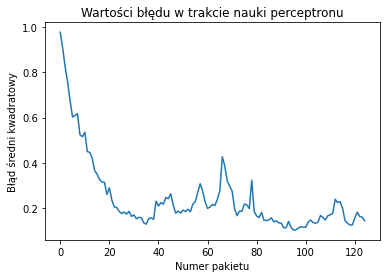

In [4]:
print(f"Najlepszy perceptron uzyskano dla funkcji aktywacji: {best_activation}, "
      f"tempa nauczania: {best_learning_rate}, "
      f"rozmiaru pakietu: {best_batch_size} "
      f"i kształtu warstw ukrytych: {best_shape}",
      f"Błąd wynosił tam {best_error:.5f}", sep="\n")

plots.generate_line_plot(
      range(len(best_mses)), best_mses,
      "Wartości błędu w trakcie nauki perceptronu",
      "Numer pakietu", "Błąd średni kwadratowy"
      )

Poniżej przedstawię wyniki uzyskane przez perceptrony dla każdej z wartości hiperparametrów.

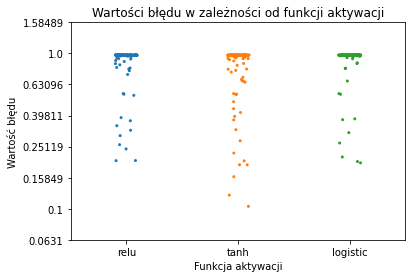

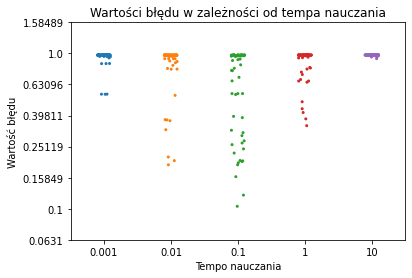

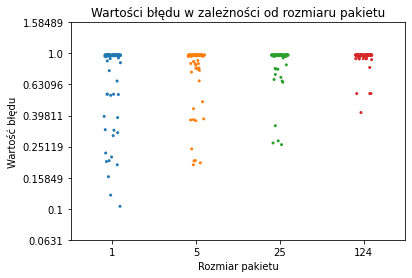

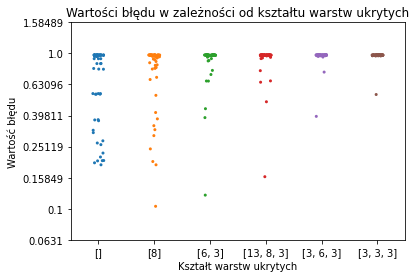

In [5]:
plots.generate_log_strip_plot(
      errors_by_activation, ACTIVATION_NAMES,
      "Wartości błędu w zależności od funkcji aktywacji",
      "Funkcja aktywacji", "Wartość błędu")

plots.generate_log_strip_plot(
      errors_by_learning_rate, LEARNING_RATES,
      "Wartości błędu w zależności od tempa nauczania",
      "Tempo nauczania", "Wartość błędu")

plots.generate_log_strip_plot(
      errors_by_batch_size, BATCH_SIZES,
      "Wartości błędu w zależności od rozmiaru pakietu",
      "Rozmiar pakietu", "Wartość błędu")

plots.generate_log_strip_plot(
      errors_by_shape, SHAPES,
      "Wartości błędu w zależności od kształtu warstw ukrytych",
      "Kształt warstw ukrytych", "Wartość błędu")

Następnie ustawiane są na najlepszym perceptronie funkcje umożliwiające mu przewidywanie na oryginalnym, nieznormalizowanym zbiorze danych.
best_perceptron.normalize zostanie wywołane na każdej próbce podanych danych, a best_perceptron.denormalize zostanie wywołane na każdym wyniku przewidywania perceptrona, zamieniając znormalizowane prawdopodobieństwa na rzeczywiste klasy.

In [6]:
best_perceptron.normalize = normalize_X
best_perceptron.denormalize = lambda Y: classes[np.argmax(Y)]

Potem sprawdzę zachowanie perceptronu na zbiorach treningowym, walidacyjnym i testowym.  
Wyświetlę macierz pomyłek i wartość dokładności (accuracy) uzyskane na każdym ze zbiorów.

In [7]:
def show_results(attributes, targets):
    confusion_matrix = training_helpers.get_confusion_matrix(targets, best_perceptron.predict_all(attributes))
    print(f"Uzyskana dokładność (accuracy): {training_helpers.get_accuracy(confusion_matrix):.3}")
    plots.show_confusion_matrix(confusion_matrix)

Zbiór treningowy:

Uzyskana dokładność (accuracy): 0.976


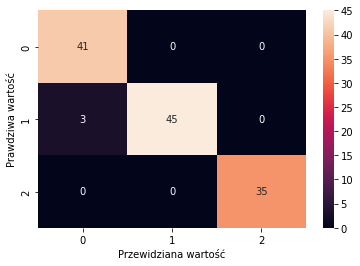

In [8]:
show_results(X_train, Y_train)

Zbiór walidacyjny:

Uzyskana dokładność (accuracy): 0.963


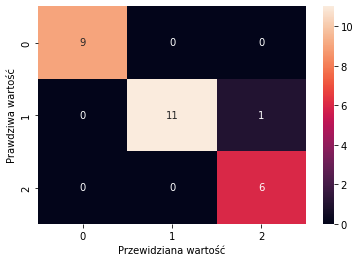

In [9]:
show_results(X_validation, Y_validation)

Zbiór testowy:

Uzyskana dokładność (accuracy): 1.0


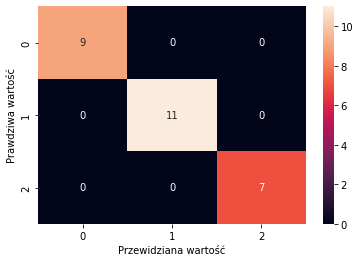

In [10]:
show_results(X_test, Y_test)

Z macierzy pomyłek wynika, że klasyfikator wykorzystujący perceptron wielowarstwowy sprawuje się bardzo dobrze na tym zbiorze danych. Jest w stanie poprawnie określić klasę prawie wszystkich win, ze wszystkich trzech zbiorów (treningowego, walidacyjnego i testowego).